# **Tratamiento de Datos, Encoding y similitud usando BERT-FINBERT**

## **0 - IMPORT y Objetos Auxiliares:**

### Imports:

In [2]:
# BASICS:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import string
from string import digits

# PROCESADO DE TEXTO
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

#!pip install cyhunspell
from hunspell import Hunspell # SOLO LINUX

# AUXILIARES
import os
import joblib
import tqdm
import contextlib

# MODELOS y ML:
import transformers
import finbert_embedding as femb
import torch

/home/alfonso/Desktop/mia/tfm/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-29 12:03:30.890461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 12:03:30.998455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-29 12:03:30.998477: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set 

### Downloads:

In [3]:
# Downloads de NLTK -  Solo en caso de no tenerlas ya
already_downloaded = True

if already_downloaded:
    None
else:
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')
    nltk.download('words'); 
    nltk.download('wordnet'); 
    nltk.download('omw-1.4'); 
    nltk.download('brown'); 
    nltk.download('movie_reviews'); 
    nltk.download('punkt'); 
    nltk.download('treebank'); 
    nltk.download('stopwords');
    

    

### F. Auxiliares y otros objetos:

Para poder ver la barra de evolución en el multiproceso

In [4]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def _call_(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super()._call_(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [5]:
# Número de nucleos disponibles por el ordenador:
cores = max(1, os.cpu_count() - 2)
print(cores)

14


## **1 - Lectura y análisis inicial de los datos**

In [6]:
raw_data = pd.read_pickle("data/fillings/dataframe_10k_20_21_22.pkl")

In [9]:
raw_data.head()

,ticker,link_to_html,item_1,filing_date
0,NPHC,https://www.sec.gov/Archives/edgar/data/111964...,Item 1. Business Introduction We were incorpo...,2021
1,CACC,https://www.sec.gov/Archives/edgar/data/885550...,"ITEM 1. BUSINESS General Since 1972, Credit A...",2020
2,HII,https://www.sec.gov/Archives/edgar/data/150158...,ITEM 1. BUSINESS History and Organization Hun...,2020
3,HR,https://www.sec.gov/Archives/edgar/data/899749...,Item 1. Business Healthcare Realty Trust Inco...,2020
4,MNKPF,https://www.sec.gov/Archives/edgar/data/156789...,Item 1. Business. Overview We are a global bu...,2020


In [10]:
raw_data.shape

(16710, 4)

In [11]:
np.unique(raw_data["filing_date"], return_counts=True)

(array(['2020', '2021', '2022'], dtype=object),
 array([4904, 5758, 6048], dtype=int64))

Existen fillings duplicados. Los eliminamos

In [9]:
num_10k_ticker = pd.pivot_table(raw_data[["ticker", "filing_date"]], index="ticker", values="filing_date", aggfunc="count")
num_10k_ticker.sort_values("filing_date", ascending=False, inplace=True)
num_10k_ticker.where(num_10k_ticker.values > 3).dropna()

,filing_date
ticker,
SIPN,14.0
CNCN,11.0
PBAJ,9.0
SVMB,9.0
CGSI,8.0
...,...
IPTK,4.0
GNRS,4.0
CWGL,4.0


In [7]:
raw_data_unique = raw_data.drop_duplicates(subset=["ticker", "filing_date"])
raw_data_unique.shape

(15842, 4)

In [10]:
num_10k_ticker_unique = pd.pivot_table(raw_data_unique[["ticker", "filing_date"]], index="ticker", values="filing_date", aggfunc="count")
num_10k_ticker_unique.sort_values("filing_date", ascending=False, inplace=True)
num_10k_ticker_unique.where(num_10k_ticker.values > 3).dropna()

,filing_date
ticker,
KBSR,3.0
MSN,3.0
MTCH,3.0
MTBC,3.0
MTB,3.0
...,...
ONEM,3.0
ONDS,3.0
ONCT,3.0


### Separamos los datos por año

In [11]:
# separamos por año y eliminamos la columna fillin_date

raw_2020 = raw_data_unique[raw_data_unique["filing_date"] == "2020"].iloc[:, :-1]
raw_2021 = raw_data_unique[raw_data_unique["filing_date"] == "2021"].iloc[:, :-1]
raw_2022 = raw_data_unique[raw_data_unique["filing_date"] == "2022"].iloc[:, :-1]

In [12]:
print(f' El año 2020 tiene {raw_2020.shape[0]} ficheros 10-K')
print(f' El año 2021 tiene {raw_2021.shape[0]} ficheros 10-K')
print(f' El año 2022 tiene {raw_2022.shape[0]} ficheros 10-K')


 El año 2020 tiene 4703 ficheros 10-K
 El año 2021 tiene 5296 ficheros 10-K
 El año 2022 tiene 5843 ficheros 10-K


Número de palabras por cada 10K filling

In [13]:
num_words_2022 = raw_2022["item_1"].str.count(' ')
num_words_2021 = raw_2021["item_1"].str.count(' ')
num_words_2020 = raw_2020["item_1"].str.count(' ')

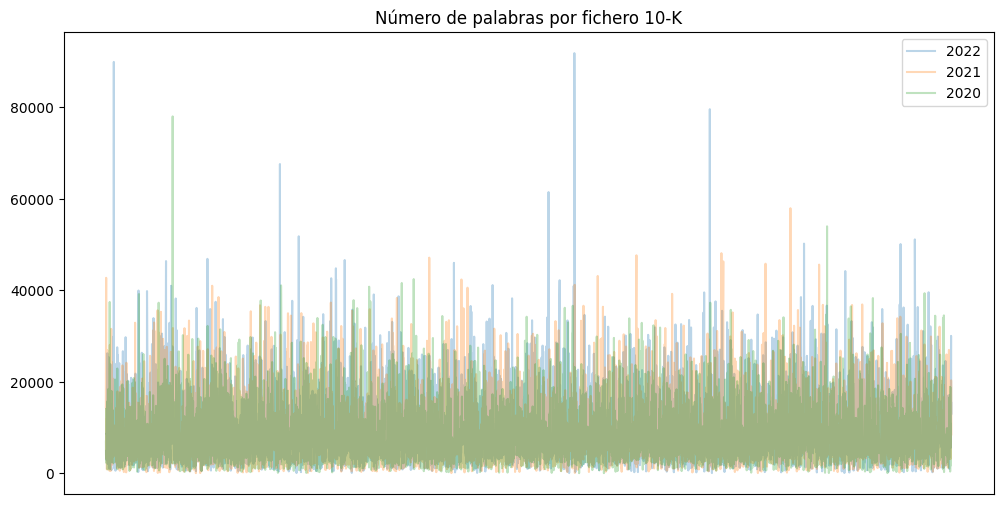

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(num_words_2022, alpha=0.3, label="2022")
plt.plot(num_words_2021, alpha=0.3, label="2021")
plt.plot(num_words_2020, alpha=0.3, label="2020")
ax.set_xticks([])
plt.legend()
plt.title("Número de palabras por fichero 10-K")
plt.show()
fig.savefig('imgs/num_words_10k.png', bbox_inches='tight')

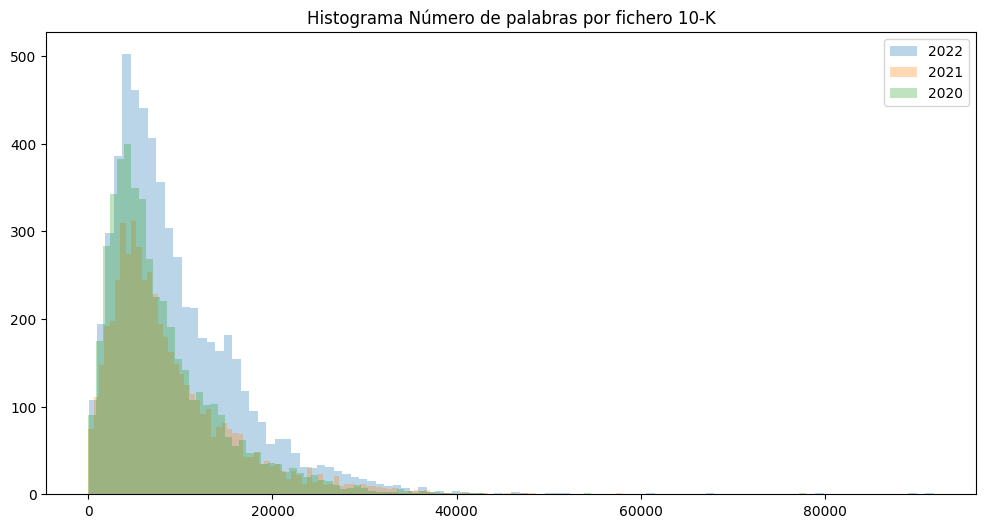

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
plt.hist(num_words_2022.values, bins=100, alpha=0.3, label="2022");
plt.hist(num_words_2021.values, bins=100, alpha=0.3, label="2021");
plt.hist(num_words_2020.values, bins=100, alpha=0.3, label="2020");
plt.legend()
plt.title("Histograma Número de palabras por fichero 10-K")
plt.show()
fig.savefig('imgs/num_words_10k_hist.png', bbox_inches='tight')

In [16]:
# 2022
print('2022:')
print(f'El número mínimo de palabras en un fichero 10-K del año 2022 es {np.min(num_words_2022.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2022 es {np.max(num_words_2022.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2022 es {int(np.mean(num_words_2022.values))}')

# 2021
print('2021:')
print(f'El número mínimo de palabras en un fichero 10-K del año 2021 es {np.min(num_words_2021.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2021 es {np.max(num_words_2021.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2021 es {int(np.mean(num_words_2021.values))}')

# 2020
print('2020:')
print(f'El número mínimo de palabras en un fichero 10-K del año 2020 es {np.min(num_words_2020.values)}')
print(f'El número máximo de palabras en un fichero 10-K del año 2020 es {np.max(num_words_2020.values)}')
print(f'El número medio de palabras en un fichero 10-K del año 2020 es {int(np.mean(num_words_2020.values))}')

2022:
El número mínimo de palabras en un fichero 10-K del año 2022 es 34
El número máximo de palabras en un fichero 10-K del año 2022 es 91803
El número medio de palabras en un fichero 10-K del año 2022 es 9683
2021:
El número mínimo de palabras en un fichero 10-K del año 2021 es 17
El número máximo de palabras en un fichero 10-K del año 2021 es 57911
El número medio de palabras en un fichero 10-K del año 2021 es 8937
2020:
El número mínimo de palabras en un fichero 10-K del año 2020 es 14
El número máximo de palabras en un fichero 10-K del año 2020 es 77974
El número medio de palabras en un fichero 10-K del año 2020 es 8137


### Limpieza inicial de los textos del año 2022

#### STOPWORDS, PUNTUACIÓN Y MAYÚSCULAS:

In [18]:
def limpieza_basica(corpus, is_string=False):
    '''
    Función que limpia un corpus (grupo de textos) y lo devuelve.
    - Quita puntuación
    - Quita dígitos
    - Transforma a minúsculas
    - Elimina espacios vacíos al principio y final
    - Elimina stopwords
    
    INPUT: Serie(columna) o lista de textos.
    OUTPUT: Idem
    '''
    
    import string
    from string import digits
    from nltk.corpus import wordnet, stopwords
    
    if is_string: # Si se le pasa una cadena de texto solo
        # Copia para emplazar los datos limpios:
        corp_copy = corpus

        # Eliminación de puntuación:
        corp_copy = corp_copy.translate(str.maketrans('', '',string.punctuation))

        # Eliminación de cifras:
        corp_copy = corp_copy.translate(str.maketrans('', '', digits))

        # Minúsculas:
        corp_copy = corp_copy.lower()

        # Limpieza de huecos al principio y final:
        corp_copy = corp_copy.strip()

        # Delimitación de stopwords inglesas
        stop_words = set(stopwords.words('english'))

        # Eliminación de Stopwords:
        corp_copy = ' '.join([word for word in corp_copy.split() if word not in (stop_words)])
    else: # Si se le pasa una columna
        
        # Copia para emplazar los datos limpios:
        corp_copy = corpus.copy()

        # Eliminación de puntuación:
        corp_copy = corp_copy.str.translate(str.maketrans('', '',string.punctuation))

        # Eliminación de cifras:
        corp_copy = corp_copy.str.translate(str.maketrans('', '', digits))

        # Minúsculas:
        corp_copy = corp_copy.str.lower()

        # Limpieza de huecos al principio y final:
        corp_copy = corp_copy.str.strip()

        # Delimitación de stopwords inglesas
        stop_words = set(stopwords.words('english'))

        # Eliminación de Stopwords:
        corp_copy = corp_copy.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    return corp_copy

In [41]:
# 20s
clean_2022 = raw_data.copy()
clean_2022 = clean_2022.loc[clean_2022.filing_date=="2022"]
clean_2022.item_1 = limpieza_basica(clean_2022.item_1)

In [43]:
print(clean_2022.shape)
clean_2022.head()

(6048, 4)


,ticker,link_to_html,item_1,filing_date
13,FSP,https://www.sec.gov/Archives/edgar/data/103131...,item business history company franklin street ...,2022
14,NEWH,https://www.sec.gov/Archives/edgar/data/137112...,item business overview developer clean energy ...,2022
15,NSP,https://www.sec.gov/Archives/edgar/data/100075...,item business general provide array human reso...,2022
16,MDV,https://www.sec.gov/Archives/edgar/data/164587...,item business company modiv internallymanaged ...,2022
28,AKRO,https://www.sec.gov/Archives/edgar/data/174465...,item businessoverviewwe clinicalstage company ...,2022


#### Limpieza de palabras usando un diccionario

In [21]:
# SOLO LINUX:
h = Hunspell()

clean_2022["item_1"] = clean_2022["item_1"].apply(
    lambda x: ' '.join(
        [word for word in x.split() 
        if h.spell(word)]
        )
    )

In [35]:
clean_2022["item_1"]

13       item business history company franklin street ...
14       item business overview developer clean energy ...
15       item business general provide array human reso...
16       item business company corporation elected qual...
28       item company developing transformational treat...
                               ...                        
16697    item business forward looking statements repor...
16704    item general information included annual repor...
16706    item business item risk factors item b unresol...
16707    item business introduction blank check company...
16708    item business company overview biotechnology c...
Name: item_1, Length: 6048, dtype: object

#### LEMATIZACIÓN:

In [24]:
# Para que el multiproceso funcione le tienes que pasar todo lo que necesita.
# Esto incluye las funciones (si son más de una) y a veces los import.

def lemmatize_sentence(sentence):
    # IMPORTS:
    import nltk
    from nltk.tokenize import RegexpTokenizer
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import wordnet, stopwords
    
    # INICIALIZAR LEMATIZADOR:
    lemmatizer = WordNetLemmatizer()
    
    
    # CONVERSIÓN DE TAG A OBJETO WORDNET:
    def nltk_pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:          
            return None

    # PROCESO INICIAL:
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    # BUCLE DE LIMPIEZA DE TEXTO
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [27]:
# EJEMPLO DE TEXTO LEMATIZADO
lemmatize_sentence(clean_2022["item_1"].iloc[0])

'item business history company franklin street property corp refer fsp corp company maryland corporation operate manner intend qualify real estate investment trust reit federal income tax purpose common stock trade nyse american symbol fsp fsp corp successor franklin street partner limit partnership fsp partnership originally form massachusetts general partnership january successor massachusetts general partnership form january fsp partnership convert fsp corp refer conversion result conversion fsp partnership cease exist succeed business fsp partnership conversion unit general limited partnership interest fsp partnership convert one share common stock result conversion hold directly indirectly interest three former subsidiary fsp partnership fsp investment llc fsp property management llc fsp holding llc operate business subsidiary business reit focus commercial real estate investment primarily office market currently operate one segment real estate operation principal revenue source r

In [44]:
# CÁLCULO CON MULTIPROCESO
with tqdm_joblib(tqdm.tqdm(desc="Lematizando", total=clean_2022["item_1"].shape[0])) as progress_bar:
    resultados = joblib.Parallel(n_jobs=cores)(joblib.delayed(lemmatize_sentence)
                                               (sentence = i) for i in clean_2022["item_1"])

Lematizando:   0%|          | 0/6048 [02:59<?, ?it/s]


In [46]:
# Generamos un dataframe con el ticker y el texto lematizado
res_2022 = pd.DataFrame()
res_2022['ticker'] = clean_2022.ticker
res_2022['text'] = resultados


In [47]:
#para guardarlo en disco y no tener que volver a calcularlo
res_2022.to_pickle('data/res_2022.pkl')

In [29]:
print(len(resultados)) # Check de longitud
print(resultados[0][:1000]) # Check de texto lematizado

6048
item business history company franklin street property corp refer fsp corp company maryland corporation operate manner intend qualify real estate investment trust reit federal income tax purpose common stock trade nyse american symbol fsp fsp corp successor franklin street partner limit partnership fsp partnership originally form massachusetts general partnership january successor massachusetts general partnership form january fsp partnership convert fsp corp refer conversion result conversion fsp partnership cease exist succeed business fsp partnership conversion unit general limited partnership interest fsp partnership convert one share common stock result conversion hold directly indirectly interest three former subsidiary fsp partnership fsp investment llc fsp property management llc fsp holding llc operate business subsidiary business reit focus commercial real estate investment primarily office market currently operate one segment real estate operation principal revenue sour

### ANÁLISIS NER PARA SEPARAR SUSTANTIVOS; ADJETIVOS Y VERBOS

In [54]:
def lista_sustantivos(texto):
    return [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(texto)) if pos[0] == 'N']

In [59]:
with tqdm_joblib(tqdm.tqdm(desc="Progreso", total=res_2022['text'].shape[0])) as progress_bar:
    res_2022['noun'] = joblib.Parallel(n_jobs=cores)(joblib.delayed(lista_sustantivos)
                                               (texto = i) for i in res_2022['text'])

Progreso:   0%|          | 0/6048 [02:45<?, ?it/s]


In [60]:
def lista_adjetivos(texto):
    return [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(texto)) if pos[0] == 'J']

In [61]:
with tqdm_joblib(tqdm.tqdm(desc="Progreso", total=res_2022['text'].shape[0])) as progress_bar:
    res_2022['adjective'] = joblib.Parallel(n_jobs=cores)(joblib.delayed(lista_adjetivos)
                                               (texto = i) for i in res_2022['text'])

Progreso:   0%|          | 0/6048 [02:43<?, ?it/s]


In [62]:
def lista_verbos(texto):
    return [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(texto)) if pos[0] == 'V']

In [63]:
with tqdm_joblib(tqdm.tqdm(desc="Progreso", total=res_2022['text'].shape[0])) as progress_bar:
    res_2022['verb'] = joblib.Parallel(n_jobs=cores)(joblib.delayed(lista_verbos)
                                               (texto = i) for i in res_2022['text'])

Progreso:   0%|          | 0/6048 [02:43<?, ?it/s]


In [64]:
def lista_adverbios(texto):
    return [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(texto)) if pos[0] == 'R']

In [65]:
with tqdm_joblib(tqdm.tqdm(desc="Progreso", total=res_2022['text'].shape[0])) as progress_bar:
    res_2022['adverb'] = joblib.Parallel(n_jobs=cores)(joblib.delayed(lista_adverbios)
                                               (texto = i) for i in res_2022['text'])

Progreso:   0%|          | 0/6048 [02:40<?, ?it/s]


In [71]:
#para guardarlo en disco y no tener que volver a calcularlo
res_2022.to_pickle('data/res_2022.pkl')

In [74]:
# Sacamos el número de palabras por tipo

num_nouns_2022 = res_2022['noun'].apply(lambda x: len(x))
num_adjectives_2022 = res_2022['adjective'].apply(lambda x: len(x))
num_verbs_2022 = res_2022['verb'].apply(lambda x: len(x))
num_adverbs_2022 = res_2022['adverb'].apply(lambda x: len(x))

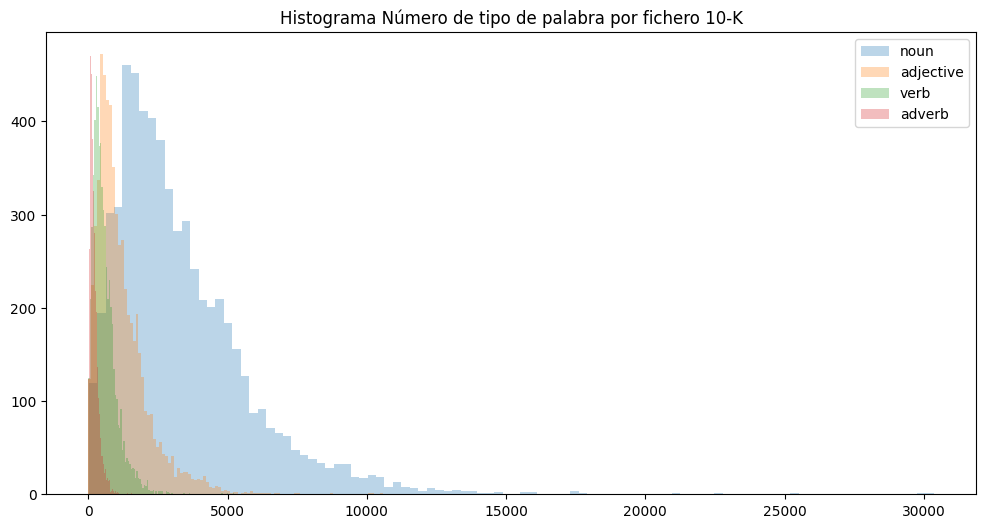

In [75]:
# Graficamos el histograma de número de palabras por tipo

fig, ax = plt.subplots(figsize=(12,6))
plt.hist(num_nouns_2022, bins=100, alpha=0.3, label="noun");
plt.hist(num_adjectives_2022.values, bins=100, alpha=0.3, label="adjective");
plt.hist(num_verbs_2022.values, bins=100, alpha=0.3, label="verb");
plt.hist(num_adverbs_2022.values, bins=100, alpha=0.3, label="adverb");
plt.legend()
plt.title("Histograma Número de tipo de palabra por fichero 10-K")
plt.show()
fig.savefig('imgs/NER_hist.png', bbox_inches='tight')

Calculamos el número de veces que aparece cada una de las palabras

In [78]:
nouns_2022 =res_2022['noun'].explode().value_counts()
adjectives_2022 =res_2022['adjective'].explode().value_counts()
adverb_2022 = res_2022['adverb'].explode().value_counts()
verbs_2022 = res_2022['verb'].explode().value_counts()

### Limpieza inicial de los textos del año 2021

In [26]:
clean_2021 = raw_data.copy()
clean_2021 = clean_2021.loc[clean_2021.filing_date=="2021"]
clean_2021.item_1 = limpieza_basica(clean_2021.item_1)

In [27]:
# SOLO LINUX:
h = Hunspell()

clean_2021["item_1"] = clean_2021["item_1"].apply(
    lambda x: ' '.join(
        [word for word in x.split() 
        if h.spell(word)]
        )
    )

In [28]:
# CÁLCULO CON MULTIPROCESO
with tqdm_joblib(tqdm.tqdm(desc="Lematizando", total=clean_2021["item_1"].shape[0])) as progress_bar:
    resultados = joblib.Parallel(n_jobs=cores)(joblib.delayed(lemmatize_sentence)
                                               (sentence = i) for i in clean_2021["item_1"])

Lematizando:   0%|          | 0/5758 [02:11<?, ?it/s]


In [30]:
res_2021 = pd.DataFrame()
res_2021['ticker'] = clean_2021.ticker
res_2021['text'] = resultados

In [31]:
#para guardarlo en disco y no tener que volver a calcularlo
res_2021.to_pickle('data/res_2021.pkl')

## **2 - EMBEDDINGS:**

### **PYPI [FINBERT-EMBEDDING](https://appliedmachinelearning.wordpress.com/2020/01/22/introducing-finbert-embedding-pypi-bert-language-model-fine-tuned-on-financial-data/):**

[GITHUB](https://github.com/abhijeet3922/finbert_embedding)

Extrae el procesado de tokens y embedding del modelo FINBERT.

**Esta librería está ROTA**. Revisando su documentación se puede apreciar como el autor vincula partes clave de la librería a localizaciones de descarga de los modelos en su propio drobox y gdrive, que ahora están rotos. Es por esto que nosotros debemos proporcionarle el modelo en la forma de un modelo descargado y señalar el path a ese modelo.

Para esa librería se ha escogido el [modelo Finbert elaborado por ProsusAI](https://huggingface.co/ProsusAI/finbert/tree/main) por ser uno de los más extendidos.

Es de destacar que en las últimas versiones los modelos se importan como una carpeta con varios documentos.

In [84]:
# Localización del modelo:

# PATH GUILLERMO:
finbert_path = "G:/Mi unidad/mIA-X_08/TFM_Alfonso/tfm/models/ProsusAI/finbert/"

# Descargar el modelo de PROSUS AI en ese path.
# El modelo son todos los archivos que hay.

In [85]:
# Creamos el 'motor' (clase) de tokenización y embedding:
fin_embedder = femb.embedding.FinbertEmbedding(model_path=finbert_path)

**Ahora podemos convertir en vectores (tokenización+embedding) palabras o frases.**

Básicamente si le pasamos una frase podemos elegir tokenizar cada palabra (un vector por palabra) o la frase entera (promedio de los vectores de cada palabra que compone la frase).

#### PALABRAS:

In [92]:
texto_prueba0 = clean_2022.item_1.iloc[0]
texto_prueba1 = clean_2022.item_1.iloc[1]
texto_prueba2 = clean_2022.item_1.iloc[2]

In [93]:
# ¿CUANTAS PALABRAS TIENEN NUESTROS EJEMPLOS?
print('EJ1 Longitud:',len(texto_prueba0.split()))
print('EJ2 Longitud:',len(texto_prueba1.split()))
print('EJ3 Longitud:',len(texto_prueba2.split()))
      

EJ1 Longitud: 2800
EJ2 Longitud: 1589
EJ3 Longitud: 5311


Podemos pasarle el texto directamente, él ya se encarga de pasarlo a vector:

In [94]:
# PALABRA:
embed_por_palabra0 = fin_embedder.word_vector(texto_prueba0)
embed_por_palabra1 = fin_embedder.word_vector(texto_prueba1)
embed_por_palabra2 = fin_embedder.word_vector(texto_prueba2)

In [95]:
# ¿CUANTOS VECTORES (PALABRAS) SE HAN TRANSFORMADO?
print('Emb1 Longitud:',len(embed_por_palabra0))
print('Emb2 Longitud:',len(embed_por_palabra1))
print('Emb3 Longitud:',len(embed_por_palabra2))

Emb1 Longitud: 430
Emb2 Longitud: 455
Emb3 Longitud: 420


In [98]:
# EL ESPACIO LATENTE TIENE 768 DIMENSIONES:
embed_por_palabra0[0].shape

torch.Size([768])

**Nótese que, desde luego, no ha cogido todas las palabras, tiende a quedarse aprox entre 400-450 palabras. ¿Por qué esta varianza? Probablemente tenga esto que ver con un límite no a las palabras sino a la longitud del texto. Hemos de considerar por tanto este límite.**

#### FRASES:

Lo anterior es relevante dado que no debemos caer en el equívoco de pensar que por hacer el embedding sobre textos largos se va a considerar el grueso del texto. Solo considera las primeras 450 palabras aproximadamente.

**Por el momento voy a trabajar bajo la asunción de que esto es representativo.**

In [99]:
# 'FRASES':
embed_por_frase0 = fin_embedder.sentence_vector(texto_prueba0)
embed_por_frase1 = fin_embedder.sentence_vector(texto_prueba1)
embed_por_frase2 = fin_embedder.sentence_vector(texto_prueba2)

embeddings = [embed_por_frase0, embed_por_frase1, embed_por_frase2]

In [100]:
# DEFINIMOS MATRIZ DE DISTANCIAS:
distance_matrix = pd.DataFrame(np.zeros((3,3)))
distance_matrix.columns = distance_matrix.index = ['Prueba1','Prueba2','Prueba3']


# RELLENAMOS:
for i in range(3):
    for j in range(3):
        distancia = scipy.spatial.distance.cosine(embeddings[i],embeddings[j])
        distance_matrix.iloc[i,j]= 1-distancia # 1 = máxima similitud

distance_matrix

,Prueba1,Prueba2,Prueba3
Prueba1,1.000000,0.849596,0.889074
Prueba2,0.849596,1.000000,0.819585
Prueba3,0.889074,0.819585,1.000000


¿Es la función de similitud por cosenos una buena aproximación? Podemos afirmar esto para las palabras, pero en las frases es más complicado defenderlo, especialmente cuando las frases (textos) son muy largos y la vectorización termina siendo un promedio. Hay que investigar más esto.

**Pero lo cierto es que con esto YA SE PUEDE METER CUALQUIER TEXTO Y ORDENAR POR SIMILITUD**

## OTROS IMPORTANTES:

### FINBERT POR DESCARGA:

Implementar Finbert de Prosus AI por descarga directa desde código

[SIN USO POR AHORA]

FINBERT DESCARGADO DIRECTAMENTE

https://metatext.io/models/prosusai-finbert

In [66]:
# CONSEGUIMOS UN MODELO Y TOKENIZADOR DE FINBERT
modelo_nombre = "ProsusAI/finbert"
modelo = transformers.AutoModel.from_pretrained(modelo_nombre)
tokenizador = transformers.AutoTokenizer.from_pretrained(modelo_nombre)

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
# TEST DE TOKENIZADO
inp = tokenizador('hello, what are you doing world', return_tensors="pt")
modelo(**inp)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0485,  0.3989, -0.7782,  ..., -1.1424, -0.4418,  0.9060],
         [-0.2865,  0.3909,  0.3491,  ..., -0.8369,  0.2176,  0.2759],
         [-0.7373,  0.5872,  0.2113,  ..., -0.8974,  0.0479,  0.5526],
         ...,
         [ 0.1837, -0.2027, -0.3213,  ..., -0.4087, -0.5724, -0.0284],
         [-0.0552,  0.0847, -0.6821,  ..., -0.1889, -0.0094,  0.3613],
         [ 0.1694,  0.0199, -0.0530,  ...,  0.0037, -0.6747,  0.3087]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.9303, -0.4025, -0.9620,  0.8960,  0.9708, -0.2374,  0.8661,  0.0139,
         -0.7555, -0.9999, -0.8831,  0.9993,  0.9941, -0.4018,  0.9793, -0.6379,
         -0.5744, -0.3711, -0.0205,  0.0289,  0.8299,  1.0000,  0.0336, -0.1803,
          0.0573,  1.0000, -0.9079,  0.9847,  0.9786,  0.8148, -0.5410, -0.1662,
         -0.9993,  0.2705, -0.9904, -0.9961,  0.5257, -0.7170,  0.3510,  0.2634,
         -0.9719, -0.0862,  1.00